In [167]:
import time
very_start_time = time.perf_counter()

from pulp import *
import math
import matplotlib.pyplot as plt
import random
import re
random.seed = 0

In [168]:
cap_order_items = math.inf

In [169]:
class Item(object):

    # each item is represented by a item_id and weight

    n_items = 400
    n_instances = 0

    def __init__(self, weight):
        Item.n_instances += 1
        self.id = Item.n_instances - 1
        self.weight = weight
        self.orders = []
        self.order_items = []

    def add_order_items(self, order_item):
        self.orders.append(order_item.order_id)
        self.order_items.append(order_item.id)

class Position(object):

    # represents a set of x, y coordinates on a grid
    # a position will be assigned to each warehouse, order and drone
    # contains a method to calculate distance to another position

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, pos2):
        return int(math.ceil(math.sqrt((self.x - pos2.x) ** 2 + (self.y - pos2.y) ** 2)))

    def __str__(self):
        return str((self.x, self.y))

class Grid(object):

    # represents a rectangular grid of a discrete number of locations
    # each moving object is assigned a position on this grid
    ## on each point there can be a warehouse, one or more order or one or more drones
    ## it is guaranteed that no order is located on the same location that a warehouse
    ## more than one drone are allowed to share a location

    def __init__(self, x, y):
        self.area = x * y

class Instructions(object):

    # represents the instruction set to submit for scoring
    # stored as a list of lists [[instr1], ...]
    # when a command is given to a drone, the related instruction is stored here
    def __init__(self):
        self.list = []

    def add_instruction(self, list):
        self.list.append(list)

class Warehouse(object):

    # represents the warehouses
    # each warehouse has a fixed position on the grid
    # inventory is given in input data, therefore loaded at instance creation
    # we see no need for a Warehouse_Item object at this point, provided we update inventory with each transaction
    ## inventory is stored as a dictionary {product_id: qty in stock}

    # WORK IN PROGRESS:
    ### the wh stores information about which orders are closer to it than to any other wh
    ### these are sorted by weight * distance
    ### the wh can respond to an inquiry from a drone to determine product availability

    n_warehouses = 10
    n_instances = 0

    def __init__(self, x, y, inventory):
        Warehouse.n_instances += 1
        self.id = Warehouse.n_instances - 1
        self.position = Position(x, y)
        self.inventory = inventory
        # self.closest_orders = []
        self.dist_to_orders = {}
        self.dist_to_order_items = {}
        self.order_items = []  #will be populated by results of optimization

    def set_distances(self, id, distance, item=False):
        # to calculate distance to every order and order_item
        if item:
            self.dist_to_order_items[id] = distance
        else:
            self.dist_to_orders[id] = distance

class Order(object):

    # orders are defined by a position and a set of items represented as a dict: {product_id : order_qty}
    #

    n_orders = 1250
    n_instances = 0

    def __init__(self, x, y, n_items, list_order_items_raw, items, warehouses):
        Order.n_instances += 1
        self.id = Order.n_instances - 1
        self.destination = Position(int(x), int(y))
        self.n_items = int(n_items)
        self.n_delivered = 0
        self.delivered = False

        # calculate distance to every warehouse, store in dict, update info in warehouses:
        self.dist_to_wh = {i: self.destination.distance(warehouses[i].position) for i in range(Warehouse.n_warehouses)}
        for each in warehouses:
            warehouses[each].set_distances(self.id, self.dist_to_wh[each], item=False)

        # calculate distance to every order, store in dict, update info in orders:
        # PENDING

        # create order_items, stored in a list inside the order:
        self.order_items = [OrderItem(order=self, item=items[int(each)], warehouses=warehouses)
                            for each in list_order_items_raw]

    def export_order_items(self):
        return

class OrderItem(Order):

    n_instances = 0

    def __init__(self, order, item, warehouses):
        OrderItem.n_instances += 1
        self.id = OrderItem.n_instances - 1

        # inherited from order
        self.order_id = order.id
        self.destination = order.destination
        self.dist_to_wh = order.dist_to_wh
        for each in warehouses:
            warehouses[each].set_distances(self.id, self.dist_to_wh[each], item=True)

        # specific to order_item
        self.item_id = item.id
        self.weight = item.weight

        self.warehouse = None # will be assigned when optimization problem is solved
        self.dist_to_oi = {} # will be calculated within the optimal cluster
        self.delivered = False

        # update list of order_items in item:
        item.add_order_items(self)

    def __str__(self):
        return str((self.order_id, str(self.destination), self.item_id, self.weight))

class Drone(object):

    n_drones = 30
    max_cap = 200
    start_x = 113
    start_y = 179

    n_instances = 0

    def __init__(self, x=start_x, y=start_y):
        Drone.n_instances += 1
        self.id = Drone.n_instances - 1
        self.position = Position(x, y)
        self.max_cap = Drone.max_cap
        self.load = 0
        self.spare_cap = self.max_cap
        self.inventory = []
        self.time_steps = 0

class Route(object):

    max_load = Drone.max_cap

    def __init__(self, order_item):

        assert order_item.weight <= Route.max_load, "exceeds max_load_1"
        self.warehouse = order_item.warehouse
        self.llist = deque([order_item])
        self.load = order_item.weight
        self.spare_cap = Route.max_load - self.load

        self.first_stop = order_item.id
        self.last_stop = order_item.id
        self.first_and_last_stops = (self.first_stop, self.last_stop)

        self.n_stops = 1
        self.total_dist = order_item.dist_to_wh[order_item.warehouse] * 2

    def merge(self, route, saving):
        if self.n_stops > 1:
            keep = self
            drop = route
        else:
            keep = route
            drop = self

        keep.update(drop, saving)
        drop.eliminate()

    def update(self, route, saving):
        if self.first_stop in saving.nodes:
            self.new_first_stop(route.llist[0])
        elif self.last_stop in saving.nodes:
            self.new_last_stop(route.llist[0])

    def eliminate(self):
        routes_list.remove(self)
        routes_dict[self.first_stop].remove(self)
        if self.n_stops > 1:
            routes_dict[self.last_stop].remove(self)

    def new_first_stop(self, order_item):

        assert order_item.weight <= self.spare_cap, "exceeds max_load_2"

        self.total_dist += order_item.dist_to_wh[order_item.warehouse] \
                           - self.llist[0].dist_to_wh[self.llist[0].warehouse] \
                           + order_item.dist_to_oi[self.first_stop]

        self.llist.appendleft(order_item)

        if self.n_stops > 1:
            routes_dict[self.first_stop].remove(self)
        self.first_stop = order_item.id
        routes_dict[self.first_stop].append(self)

        self.first_and_last_stops = (self.first_stop, self.last_stop)
        self.n_stops += 1
        self.load += order_item.weight
        self.spare_cap = Route.max_load - self.load



    def new_last_stop(self, order_item):

        assert order_item.weight <= self.spare_cap, "exceeds max_load_3"

        self.total_dist += order_item.dist_to_wh[order_item.warehouse] \
                           - self.llist[-1].dist_to_wh[self.llist[0].warehouse] \
                           + order_item.dist_to_oi[self.last_stop]

        self.llist.append(order_item)

        if self.n_stops > 1:
            routes_dict[self.last_stop].remove(self)
        self.last_stop = order_item.id
        routes_dict[self.last_stop].append(self)

        self.first_and_last_stops = (self.first_stop, self.last_stop)
        self.n_stops += 1
        self.load += order_item.weight
        self.spare_cap = Route.max_load - self.load

class Saving(object):

    def __init__(self, wh, node_1, node_2, saving):

        self.warehouse = wh
        self.nodes = (node_1, node_2)
        self.saving = saving
        self.used = None  # will be modified by algorithm

    def __lt__(self, other):
        return self.saving <= other.saving

    def __str__(self):
        return str(self.nodes) + ", " + str(self.saving)

    def __eq__(self, other):
        return self.nodes == other.nodes + self.nodes == other.nodes[::-1]



In [170]:
def string_to_list(astring):
    return astring.split(" ")

def string_to_dict(astring):
    alist = string_to_list(astring)
    adict = {}
    for i in range(len(alist)):
        adict[i] = int(alist[i])
    return adict

def plot_wh_and_orders(wh, orders):
    wh_x_list = [wh[i].x for i in range(len(wh))]
    wh_y_list = [wh[i].y for i in range(len(wh))]
    order_x_list = [orders[i].x for i in range(len(orders))]
    order_y_list = [orders[i].y for i in range(len(orders))]

    plt.plot(order_x_list, order_y_list, 'o', color='r')
    plt.plot(wh_x_list, wh_y_list, '^', color='b')

    plt.axis([0, 400, 0, 600])
    plt.show()

    return

def sample_orders(orders, k):
    # returns a sample of k orders from the initial dataset
    idx_sel = random.choices(population=range(orders[0].n_orders), k=k)

    result = {}
    for i in range(k):
        result[i] = orders[idx_sel[i]]

    return result

def quicksort(array, asc=False):

    if len(array) < 2:
        return array

    low, same, high = [], [], []

    pivot = array[random.randint(0, len(array) - 1)]

    for item in array:
        if item < pivot:
            low.append(item)
        elif item == pivot:
            same.append(item)
        elif item > pivot:
            high.append(item)

    if asc:
        return quicksort(low, asc) + same + quicksort(high, asc)
    if not asc:
        return quicksort(high, asc) + same + quicksort(low, asc)

In [171]:
weight = string_to_dict(
    "73 40 84 107 52 36 13 74 36 94 93 46 123 24 100 93 62 49 97 102 80 37 22 25 72 48 40 74 32 31 136 64 99 37 44 36 104 74 112 40 65 67 50 143 23 26 91 20 142 128 9 77 40 26 55 104 59 112 42 69 87 89 2 11 105 43 105 23 21 88 57 40 52 63 35 141 54 27 45 37 21 37 102 38 36 117 57 93 24 52 83 133 51 102 34 52 39 54 64 146 127 100 58 50 49 40 55 123 64 30 127 63 19 59 31 22 68 37 107 68 52 61 35 38 76 44 21 144 21 40 105 48 97 70 74 95 75 28 25 40 81 72 58 99 52 5 72 84 53 21 110 97 30 43 92 109 39 89 51 30 102 94 13 45 93 94 90 104 36 55 92 12 45 126 73 132 118 127 125 26 83 69 49 39 4 63 84 47 75 43 82 43 51 28 118 110 42 2 53 74 54 57 92 23 72 95 76 35 38 100 52 34 58 74 86 25 32 61 39 55 76 68 107 82 97 108 57 38 88 71 22 40 63 37 80 51 52 52 67 101 49 46 100 52 63 36 53 45 51 56 71 50 13 29 18 36 87 86 39 11 148 74 74 121 11 28 65 79 32 85 95 26 43 123 81 78 25 100 27 90 53 60 100 25 72 80 83 40 62 53 40 97 105 56 49 100 36 46 80 8 23 58 78 58 24 78 67 62 85 80 39 34 62 33 58 130 41 34 33 62 129 79 103 104 56 33 118 96 21 18 65 140 87 91 61 54 137 71 84 35 75 32 4 68 37 80 78 91 75 52 74 96 32 85 42 78 119 58 16 44 24 98 121 76 16 56 112 67 58 46 76 45 41 94 55 44 51 136 63 34 86 87 64 54 27 69 31 64 138 56 97 81 40 132 64 114 105 41 52 60")

warehouse_raw = [
    [113, 179, string_to_dict(
        "0 0 5 1 0 0 0 0 2 0 4 0 0 0 0 8 11 5 0 0 0 4 0 0 0 0 7 0 0 0 0 46 1 6 3 9 3 3 2 0 3 0 1 4 0 3 2 1 3 0 2 0 2 0 0 0 0 9 0 0 2 5 1 4 13 1 0 0 0 0 5 0 16 50 3 0 4 1 0 0 0 5 2 2 0 4 0 0 3 0 0 2 23 0 0 2 10 0 0 7 11 1 0 8 9 0 1 0 0 2 6 6 2 0 6 3 0 0 1 3 5 0 3 2 4 0 3 9 0 2 0 0 2 10 0 0 4 4 2 0 15 0 0 1 4 0 1 0 0 5 6 5 2 0 6 0 0 67 0 0 0 0 0 8 5 0 0 6 59 3 0 0 8 3 0 1 1 1 4 29 3 6 38 0 0 0 7 1 1 4 2 1 0 0 7 0 0 0 0 5 0 7 1 1 1 6 1 0 3 0 8 0 0 0 4 4 7 0 7 9 0 7 0 6 0 4 0 4 0 1 3 0 0 0 0 0 2 8 0 8 3 5 10 6 0 1 2 46 0 11 0 0 4 1 0 1 0 0 0 4 1 0 2 3 0 0 1 0 4 11 8 5 46 0 0 3 54 40 7 0 3 2 0 11 0 3 0 2 2 0 8 2 1 5 6 0 57 8 0 12 7 6 0 0 2 0 0 0 0 0 4 0 0 1 2 0 0 4 1 0 0 0 2 4 0 2 4 2 2 1 3 0 0 0 0 0 0 0 0 0 1 0 3 2 0 3 0 5 5 0 5 0 0 0 0 0 0 0 0 3 8 4 0 0 0 0 0 0 10 0 0 2 0 36 1 5 0 2 5 0 0 15 5 5 0 4 0 1 0 0 3 2 0 2 0 0 11 6 7 0")
     ],
    [234, 599, string_to_dict(
        "0 0 3 1 1 0 0 0 2 0 6 0 0 0 0 9 4 4 0 0 0 1 0 0 5 0 6 0 50 0 0 0 7 0 2 7 0 2 2 18 0 0 4 3 0 2 4 1 6 0 4 0 8 0 79 0 0 6 0 0 2 2 2 7 4 1 0 0 0 0 4 0 0 0 2 4 0 3 0 0 0 15 0 6 0 1 0 0 4 0 0 1 0 0 0 5 3 0 3 4 6 2 0 0 10 0 5 0 0 2 5 7 3 0 11 0 0 1 2 4 4 0 7 7 3 0 5 11 0 8 0 0 6 6 0 0 10 1 2 0 0 1 0 4 3 0 2 36 0 7 3 4 1 0 4 0 2 0 0 0 0 0 0 10 3 0 0 10 0 2 0 15 6 3 0 3 2 1 1 0 4 4 0 0 0 0 4 1 3 6 0 6 3 0 3 0 0 2 38 2 0 7 2 3 3 6 1 0 4 2 2 47 0 0 5 6 7 0 12 5 0 10 0 0 0 5 0 6 0 3 1 0 0 0 1 0 1 8 0 9 0 9 9 2 0 1 0 0 0 0 0 0 7 5 0 0 0 0 0 0 3 55 8 0 0 0 4 0 5 0 8 0 0 0 0 8 0 0 8 0 4 3 0 7 0 0 0 8 5 0 6 0 2 1 0 0 0 5 0 6 8 4 0 0 1 0 0 0 0 0 0 0 0 0 6 0 10 4 0 0 0 0 3 2 0 2 2 6 3 0 2 0 0 16 0 0 0 0 78 0 1 0 4 0 0 2 0 6 9 36 5 0 0 0 0 0 33 2 0 2 9 4 0 19 0 0 0 0 0 0 64 6 0 0 1 14 0 7 1 0 0 0 8 4 0 5 0 1 0 11 7 9 0 1 0 0 5 7 11 0")
     ],
    [195, 89, string_to_dict(
        "0 0 1 3 0 0 0 36 4 1 2 0 0 0 0 5 6 5 0 0 0 0 0 0 1 0 4 0 0 0 43 0 7 0 3 6 1 1 3 0 0 0 1 2 7 5 1 2 1 64 10 0 2 0 0 18 14 5 0 0 4 5 2 8 4 0 0 0 0 0 2 0 0 0 3 4 2 1 0 0 0 5 0 7 12 3 0 15 3 0 0 1 0 0 0 0 5 0 0 8 11 1 0 0 11 0 1 0 0 2 4 9 2 0 9 2 0 1 3 5 3 0 5 5 4 0 1 9 0 8 0 0 5 7 0 0 4 1 4 0 0 1 0 2 2 0 3 0 0 6 4 6 0 0 9 0 2 0 41 0 0 0 0 7 9 0 10 7 0 1 0 0 8 2 0 3 2 0 1 0 2 1 0 0 0 0 5 1 3 6 1 2 0 28 6 0 0 1 0 2 2 5 3 2 0 2 1 0 1 0 4 0 0 0 4 2 6 0 1 5 0 5 41 1 0 10 0 6 0 1 2 0 0 0 1 0 2 5 0 3 0 8 7 2 0 1 1 0 2 0 1 0 4 3 25 1 0 0 0 3 1 0 6 3 0 0 1 0 4 0 4 0 0 0 0 4 0 0 9 0 3 2 0 6 60 2 0 3 1 0 7 1 1 2 0 0 0 10 0 6 7 3 43 0 2 0 0 0 0 19 1 0 0 2 3 0 0 2 0 19 0 0 4 6 0 1 4 3 4 3 3 0 0 0 30 0 0 0 0 0 1 0 1 3 0 1 0 3 6 0 3 0 0 0 1 0 0 1 28 0 4 6 0 0 0 0 0 0 0 0 0 2 0 0 0 10 0 6 4 0 0 0 6 6 84 0 0 0 72 0 3 0 0 1 0 0 5 5 5 0")
     ],
    [215, 207, string_to_dict(
        "1 0 4 0 1 0 15 0 2 0 4 0 0 10 0 4 9 4 41 0 7 1 0 0 5 0 11 40 0 0 0 0 6 0 1 8 4 5 3 0 2 0 2 1 0 8 4 3 5 0 4 0 1 0 0 0 0 6 0 0 4 4 3 6 4 2 0 0 0 0 6 0 0 0 5 8 3 3 0 0 42 7 0 5 0 3 0 0 4 0 0 0 0 0 29 0 7 0 0 7 7 1 0 0 7 0 4 0 0 1 4 5 3 0 8 0 0 3 1 5 4 75 7 2 1 0 4 8 0 5 0 0 5 10 0 20 11 0 4 0 0 4 0 1 0 0 1 0 0 8 2 3 0 69 3 0 2 0 0 75 0 0 0 10 11 0 0 6 0 1 0 0 7 2 0 8 2 2 3 0 3 5 0 0 0 0 7 0 3 7 3 1 4 0 2 0 0 2 0 6 2 8 3 2 4 6 5 0 2 0 2 0 0 0 7 1 6 0 4 3 0 7 0 3 36 3 0 6 34 3 1 0 0 47 3 0 0 4 0 5 0 7 6 13 0 3 0 0 1 0 0 0 3 3 0 3 0 0 0 3 2 0 3 1 13 0 1 0 3 0 7 0 0 0 0 4 0 0 7 0 2 2 60 8 0 3 0 5 2 0 10 0 4 5 0 0 0 5 0 14 5 7 0 0 4 0 0 0 22 0 1 11 0 0 7 0 0 0 0 0 0 0 2 4 0 1 5 6 6 2 2 0 0 0 0 0 0 0 0 0 1 9 2 0 0 6 73 4 7 0 9 0 0 0 2 0 0 0 0 0 4 4 0 0 0 0 14 0 0 0 0 5 77 0 0 11 0 3 5 0 42 0 8 4 0 2 0 1 0 0 3 4 0 3 0 0 6 5 8 0")
     ],
    [220, 326, string_to_dict(
        "1 0 6 1 2 0 0 0 2 1 6 13 0 0 0 2 9 6 0 0 0 1 0 0 1 0 8 0 0 0 0 0 8 0 1 9 1 0 5 0 1 0 1 4 0 6 3 1 1 0 5 0 4 0 0 0 0 7 0 13 2 3 2 10 6 0 0 0 0 0 3 0 0 0 4 5 3 3 39 0 0 6 3 3 0 4 56 0 3 0 0 2 0 0 0 2 5 0 0 8 7 1 0 0 6 0 0 0 0 0 4 5 7 0 6 1 0 2 0 2 5 0 3 1 1 0 3 11 0 7 0 0 1 7 0 0 8 1 5 40 0 1 0 0 2 0 2 0 0 8 4 1 2 0 7 16 1 0 0 0 0 0 51 5 8 0 0 6 0 2 0 0 6 1 0 4 0 0 1 0 2 2 0 0 0 50 1 0 0 9 3 5 2 0 6 0 0 1 0 1 2 8 2 5 5 6 1 0 7 1 6 0 0 3 6 1 11 0 8 7 0 9 0 5 0 4 18 4 0 4 3 0 0 0 0 0 3 8 0 3 0 1 13 5 0 2 1 0 4 0 0 0 7 2 0 2 0 0 0 4 2 0 8 0 0 0 0 0 3 0 12 0 0 26 0 3 0 0 12 0 3 3 0 7 0 3 0 13 2 0 13 3 1 6 0 0 0 8 0 5 3 3 0 0 1 0 31 0 0 0 0 0 0 3 5 0 0 2 1 0 0 0 3 4 0 0 1 3 1 0 1 0 0 0 0 0 0 0 0 0 1 0 6 1 0 2 0 5 9 0 5 0 21 0 0 0 0 1 0 1 8 4 0 0 0 0 0 0 0 0 0 3 0 0 4 9 0 2 5 0 0 0 4 1 0 1 0 0 0 0 3 0 0 3 25 0 2 2 6 0")
     ],
    [182, 193, string_to_dict(
        "0 16 3 0 1 0 0 0 5 0 3 0 0 0 0 6 8 2 0 0 0 3 0 19 2 0 9 0 0 0 0 0 3 0 0 9 2 3 3 0 3 0 0 5 0 5 5 3 2 0 4 0 6 0 0 0 0 12 0 0 5 3 2 7 9 1 0 0 0 0 1 66 0 0 1 6 6 2 0 0 0 7 1 5 0 3 0 0 2 0 0 0 0 0 0 1 11 0 1 9 6 1 0 0 10 0 2 0 0 1 3 6 2 63 8 0 0 1 0 3 3 0 5 1 1 0 1 8 0 8 0 0 6 12 0 0 11 3 5 0 0 4 0 0 4 0 1 0 0 6 4 5 1 0 7 0 1 0 0 0 0 0 0 8 6 0 0 3 0 1 0 0 8 2 0 3 3 2 2 0 5 1 0 49 74 0 5 1 3 3 5 2 2 0 7 0 36 3 0 2 2 8 0 3 2 8 1 0 5 1 3 0 17 0 1 2 6 0 7 3 0 7 0 1 0 6 0 2 0 1 3 0 12 0 0 0 1 10 0 7 0 7 6 5 40 2 0 0 1 0 1 0 3 2 0 1 0 0 0 1 1 0 0 1 0 0 3 0 5 0 7 0 0 0 0 3 0 0 6 0 1 2 0 7 0 5 82 6 6 0 3 0 4 2 0 0 0 9 0 7 4 4 0 0 3 0 0 0 0 0 1 0 0 1 6 0 0 1 0 0 0 0 5 3 0 1 0 3 5 1 1 0 0 0 0 0 0 0 0 16 1 0 4 0 48 2 0 3 4 0 6 0 0 0 2 0 0 1 0 2 16 2 0 0 53 0 0 0 0 0 0 6 0 0 3 6 34 5 1 0 0 0 8 5 0 0 0 1 0 0 2 2 0 1 0 33 5 9 5 0")
     ],
    [75, 418, string_to_dict(
        "1 0 6 0 1 0 0 0 10 0 3 0 0 0 0 4 11 6 0 0 0 1 0 0 2 0 12 0 0 0 0 0 2 0 2 6 4 6 2 0 3 0 1 7 0 2 2 3 8 0 5 35 0 29 0 0 0 5 0 0 5 3 1 8 6 0 0 0 0 0 4 0 0 0 0 4 6 0 0 16 0 12 1 1 0 4 0 0 4 31 46 2 0 0 0 3 11 0 0 1 4 2 0 0 5 0 2 93 0 2 3 5 4 0 7 4 0 2 3 5 4 0 8 4 1 0 5 13 0 10 0 0 6 10 0 0 6 0 3 0 0 2 70 1 1 0 2 0 0 9 5 2 2 0 11 0 0 0 0 0 0 0 0 8 7 0 0 6 0 3 17 0 7 2 26 1 0 1 2 0 1 3 0 0 0 0 7 0 2 5 1 2 2 0 7 41 0 6 0 5 2 5 1 7 3 4 1 0 4 1 2 0 0 0 6 5 11 7 5 10 0 6 0 2 0 5 0 5 0 0 2 22 0 0 0 0 0 5 47 2 0 1 9 7 0 2 0 0 2 0 0 0 7 1 0 4 0 0 0 3 4 0 9 1 0 0 0 0 1 0 12 0 0 0 9 9 0 0 13 0 4 2 0 10 0 2 0 2 3 0 4 0 2 8 0 0 0 7 0 9 4 6 0 0 0 21 0 0 0 0 1 0 0 1 5 0 0 2 0 0 0 11 2 3 0 0 5 1 8 2 4 0 0 0 0 64 0 0 0 0 0 0 3 7 0 4 0 4 11 0 8 0 0 0 2 0 0 1 0 2 11 6 98 0 0 44 0 0 0 0 0 2 0 0 2 8 0 2 3 0 0 0 6 5 0 2 0 2 0 0 3 6 0 2 0 0 5 5 5 60")
     ],
    [228, 140, string_to_dict(
        "0 0 6 0 0 0 0 0 5 0 5 0 0 0 0 6 8 4 0 38 0 1 0 0 5 0 6 0 0 0 0 0 5 0 2 11 1 3 2 0 2 0 1 2 0 3 4 6 4 0 5 0 4 0 0 0 0 7 0 0 4 3 3 6 2 2 0 0 53 0 6 0 0 0 0 2 5 1 0 0 0 3 0 8 0 6 0 0 1 0 0 0 0 18 0 4 9 64 2 6 7 0 0 0 6 56 3 0 49 2 2 3 3 0 5 2 0 0 2 7 5 0 3 2 3 0 2 10 0 10 0 0 8 10 3 0 8 0 4 0 0 1 0 1 1 54 2 0 0 11 2 2 1 0 3 0 1 0 0 0 0 0 0 7 3 0 0 10 0 4 0 0 5 2 0 4 0 4 2 0 1 3 0 0 0 0 1 0 1 10 2 5 4 0 1 0 0 1 0 4 4 9 1 4 3 3 2 0 2 2 7 0 0 0 11 1 8 0 7 7 89 11 0 7 0 4 0 3 0 2 1 0 0 0 0 0 1 6 0 7 0 6 7 3 0 2 1 0 2 0 1 0 1 3 0 2 0 0 0 3 5 0 5 2 0 0 1 0 5 0 5 0 0 0 0 1 0 0 10 0 2 2 0 14 0 4 0 7 6 51 4 0 1 5 0 0 0 5 0 11 6 6 0 0 0 0 0 0 0 0 1 0 0 4 9 0 0 0 0 0 36 0 4 5 0 0 4 0 2 1 1 11 40 0 0 0 21 0 0 0 4 0 2 2 0 4 0 3 6 0 12 0 0 0 1 0 0 1 0 2 9 1 0 0 0 0 0 0 0 0 0 8 0 0 4 5 0 8 1 0 0 0 14 7 0 1 0 2 0 0 2 1 61 1 0 0 8 6 9 0")
     ],
    [310, 26, string_to_dict(
        "1 0 8 1 0 33 0 0 1 1 6 0 0 0 0 3 11 0 0 0 0 6 17 0 2 0 10 0 0 0 0 0 11 0 3 5 3 1 5 0 2 69 2 3 0 5 0 2 2 0 3 0 6 0 0 0 0 5 0 0 3 3 3 7 9 0 78 32 0 0 1 0 0 0 0 5 1 0 0 0 0 7 1 5 0 4 0 0 1 0 0 1 0 0 0 1 6 0 0 6 8 3 16 0 12 0 3 0 0 1 4 5 5 0 15 1 0 1 5 5 3 0 3 1 2 52 4 7 0 7 67 13 3 5 0 0 6 1 2 0 0 4 0 0 1 0 3 0 3 7 2 4 0 0 6 0 1 0 0 0 0 67 0 8 8 19 0 6 0 1 0 0 7 0 0 2 0 1 3 0 0 4 0 0 0 0 5 4 2 5 3 1 1 0 5 0 0 0 0 1 2 6 0 4 1 4 3 0 1 0 4 0 0 0 3 4 5 0 7 4 0 10 0 6 0 4 0 3 0 0 1 0 0 0 1 0 3 9 0 8 0 1 4 4 0 2 1 0 1 0 1 0 6 4 0 3 0 61 9 10 3 0 3 0 0 0 3 54 6 0 10 0 0 0 0 4 0 0 10 23 2 4 0 4 0 5 0 6 3 0 5 1 1 4 0 0 0 3 19 4 1 6 0 0 2 0 0 28 0 0 1 0 53 1 3 34 0 1 1 0 0 0 5 2 29 0 4 1 4 1 2 0 0 0 0 0 0 0 0 0 2 0 0 2 0 3 0 3 9 0 10 8 0 0 1 48 0 2 0 1 6 3 0 0 0 0 0 42 0 0 0 7 0 0 2 9 0 5 0 0 0 0 7 7 0 1 0 2 0 0 4 3 0 1 0 0 11 6 13 0")
     ],
    [297, 423, string_to_dict(
        "1 0 4 2 0 0 0 0 6 0 9 0 23 0 40 3 7 0 0 0 0 2 0 0 1 16 3 0 0 25 0 0 5 0 2 7 2 2 3 0 2 0 3 2 0 3 3 3 3 0 8 0 10 0 0 0 0 4 43 0 4 4 3 11 4 1 0 0 0 11 4 0 0 0 3 6 4 2 0 0 0 3 0 3 0 6 0 0 3 0 0 1 0 0 0 1 6 0 1 5 7 1 0 0 12 0 7 0 0 7 3 1 8 0 6 1 46 0 1 2 3 0 5 1 1 0 2 8 16 10 0 0 6 12 0 0 8 0 5 0 0 1 0 0 1 0 1 0 0 0 4 7 2 0 8 0 0 0 0 0 85 0 0 4 5 0 0 4 0 3 0 0 3 2 0 6 1 2 0 0 0 5 0 0 0 0 3 0 4 8 1 2 2 0 2 0 0 4 0 2 0 7 0 3 1 7 0 5 2 2 4 0 0 0 7 2 13 0 5 4 0 6 0 2 0 7 0 4 0 4 3 0 0 0 2 36 2 7 0 2 0 8 8 5 0 0 0 0 0 0 1 37 1 6 0 5 25 0 0 4 1 0 9 4 0 45 2 0 4 0 9 0 0 0 0 3 0 0 6 0 1 1 0 7 0 2 0 6 2 0 3 2 0 3 0 14 0 7 0 4 5 8 0 57 1 0 0 0 0 0 1 0 0 3 4 0 0 1 1 0 0 0 2 5 0 0 2 1 7 1 2 0 0 0 0 0 0 41 0 0 1 0 5 3 0 3 0 6 9 0 8 0 0 38 2 0 0 0 0 5 6 4 0 0 0 0 0 0 0 22 0 6 0 0 4 6 0 4 2 24 0 0 8 4 0 1 36 0 0 0 3 6 0 2 0 0 7 5 6 0")
     ]
]

with open('busy_day.in', mode='r') as file:
    lines_list = file.read().splitlines()

orders_raw = []
start = 25
for i in range(Order.n_orders):
    orders_raw.append([lines_list[start + i * 3 + j] for j in range(3)])

In [172]:
grid = Grid(400, 600)
instructions = Instructions()

items = {i: Item(weight=int(weight[i])) for i in range(Item.n_items)}

warehouses = {i: Warehouse(x=warehouse_raw[i][0], y=warehouse_raw[i][1], inventory=warehouse_raw[i][2])
              for i in range(Warehouse.n_warehouses)}

drones = {i: Drone() for i in range(Drone.n_drones)}


# create Orders, depending on cap_order_items
orders = {}
k = 0
for i in range(Order.n_orders):
    if int(orders_raw[i][1]) <= cap_order_items:
        orders[k] = Order(x=string_to_list(orders_raw[i][0])[0], y=string_to_list(orders_raw[i][0])[1],
                       n_items=int(orders_raw[i][1]), list_order_items_raw=string_to_list(orders_raw[i][2]),
                       items=items, warehouses=warehouses)
        k += 1

## former procedure, create all orders:
# orders = {i: Order(x=string_to_list(orders_raw[i][0])[0], y=string_to_list(orders_raw[i][0])[1],
#                    n_items=orders_raw[i][1], list_order_items_raw=string_to_list(orders_raw[i][2]),
#                    items=items, warehouses=warehouses) for i in range(Order.n_orders)}

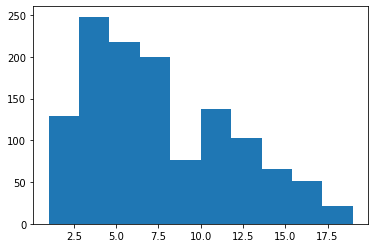

In [173]:
n_items = [orders[each].n_items for each in orders]
n_items = quicksort(n_items, asc=True)

plt.hist(n_items)
plt.show()


In [174]:
order_items = {orders[each].order_items[i].id: orders[each].order_items[i] for each in orders for i in range(len(orders[each].order_items))}

In [175]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html

supply_nodes = [warehouses[i].id for i in range(warehouses[0].n_warehouses)]  # list of warehouse.id

demand_nodes = [orders[i].order_items[j].id for i in range(len(orders)) for j in  # list of order_item.id
                range(orders[i].n_items)]

products = [items[i].id for i in items]  # list of item.id
product_by_order_item = [orders[i].order_items[j].item_id   # list of item.id by order_item
                         for i in range(len(orders))
                         for j in range(orders[i].n_items)]

supply = {i: warehouses[i].inventory for i in range(warehouses[0].n_warehouses)}

demand = {i: {product_by_order_item[i]: 1} for i in demand_nodes}

routes = list(zip(demand_nodes, product_by_order_item))
routes = [(w, oi_p[0], oi_p[1]) for w in supply_nodes for oi_p in routes]  # list of (warehouse.id, order_item.id, item.id

costs = [
        [warehouses[i].dist_to_order_items[j] for j in range(orders[0].order_items[0].n_instances)]
         for i in range(warehouses[0].n_warehouses)
        ]
costs = makeDict([supply_nodes, demand_nodes], costs, 0)


In [176]:
model = LpProblem(name='transportation', sense=LpMinimize)
vars = LpVariable.dicts("route", routes, lowBound=0, upBound=1, cat='Integer') # define variables

# objective function
model += lpSum([vars[(w, oi, p)] * costs[w][oi] for (w, oi, p) in routes]), "Sum_of_Transporting_Costs"

# constraints
# supply
for w in supply_nodes:
    for p in products:
        model += lpSum([vars[w, oi, p] for oi in items[p].order_items]) <= supply[w][p],\
                 "Sum_of_Products_%s_out_of_Warehouse_%d" %(p, w)

# demand
count = 0
for i in range(len(demand_nodes)):
    model += lpSum([vars[w, demand_nodes[i], product_by_order_item[i]] for w in warehouses]) >= demand[demand_nodes[i]][product_by_order_item[i]], \
             "Sum_of_Products_%s_into_Order_item_%d" %(product_by_order_item[i], demand_nodes[i])

# model.to_json("transpo.txt")
# model.writeLP("transpo.lp")

In [177]:
start_time = time.perf_counter()
model.solve()
end_time = time.perf_counter()

print(f"Solved in {(end_time - start_time):0.4f} seconds")
print("Status:", LpStatus[model.status])
print("Total Cost of Transportation = ", value(model.objective))

Solved in 2.6605 seconds
Status: Optimal
Total Cost of Transportation =  1238979.0


In [178]:
solved_var = [each.name for each in model.variables() if each.varValue == 1.0]
solved_var = [re.findall('\d+', each) for each in solved_var]

for each in solved_var:
    order_items[int(each[1])].warehouse = int(each[0])
    warehouses[int(each[0])].order_items.append(int(each[1]))

In [179]:
start_time = time.perf_counter()

for wh_id in warehouses:
    for i in range(len(warehouses[wh_id].order_items)):
        oi_1 = order_items[warehouses[wh_id].order_items[i]]
        for j in range(i+1,len(warehouses[wh_id].order_items)):
            oi_2 = order_items[warehouses[wh_id].order_items[j]]
            dist = oi_1.destination.distance(oi_2.destination)
            oi_1.dist_to_oi[oi_2.id] = dist
            oi_2.dist_to_oi[oi_1.id] = dist

end_time = time.perf_counter()
print(f"Solved in {(end_time - start_time):0.4f} seconds")

Solved in 7.0092 seconds


In [180]:
start_time = time.perf_counter()
from collections import deque

routes_list = []
routes_dict = {}

# build the list of initial routes:
routes_list = [Route(order_items[each]) for each in order_items]

# index routes_list in a dict, by the stop_id of first or last:

for each in order_items:
    routes_dict[each] = []

for route in routes_list:
    for each in route.first_and_last_stops:
        if route not in routes_dict[each]:
            routes_dict[each].append(route)

# this needs to be updated incrementally after each merge

end_time = time.perf_counter()
print(f"Solved in {(end_time - start_time):0.4f} seconds")


Solved in 0.0160 seconds


In [181]:
start_time = time.perf_counter()

# savings = [Saving(key, nested_key,
#                   distances_dc[key] + distances_dc[nested_key] - distances[key][nested_key])
#            for key in distances for nested_key in distances[key]]

savings = {i:[] for i in warehouses}

for i in warehouses:
    for j in warehouses[i].order_items:
        for k in order_items[j].dist_to_oi:
            if k > j:
                savings[i].append(Saving(wh=i, node_1=j, node_2=k,
                              saving=order_items[j].dist_to_wh[i]
                              + order_items[k].dist_to_wh[i]
                              - order_items[j].dist_to_oi[k])
               )


end_time = time.perf_counter()
print(f"Solved in {(end_time - start_time):0.4f} seconds")

Solved in 11.6822 seconds


In [182]:
start_time = time.perf_counter()

# create a dict of savings, indexed by warehouse then saving.used - the 'None' are sorted DESC:
for i in range(warehouses[0].n_warehouses):
    savings[i] = {'None': savings[i], 'True': [], 'False': []}
    savings[i]['None'].sort(reverse=True)

end_time = time.perf_counter()
print(f"Solved in {(end_time - start_time):0.4f} seconds")

Solved in 5.0795 seconds


In [183]:
start_time = time.perf_counter()

for i in range(warehouses[0].n_warehouses):

    # 1- select TOP saving from ordered list of candidates:
    for saving_candidate in savings[i]['None']:

        # 2- select routes that start or end with one of the candidate's nodes - must be strictly less than 3:
        routes_before = [each for each in routes_dict[saving_candidate.nodes[0]]] # search for node[0]
        routes_before.extend([each for each in routes_dict[saving_candidate.nodes[1]] if each not in routes_before])  # search for node[1]
        assert len(routes_before) < 3, "too many routes, check selection"

        # 3- if exactly 2 routes and combined load less than max:
        if len(routes_before) == 2:
            if routes_before[0].load + routes_before[1].load <= routes_before[0].max_load:
                routes_before[0].merge(routes_before[1], saving_candidate)
                saving_candidate.used = True
                # savings['None'].remove(saving_candidate)
                savings[i]['True'].append(saving_candidate)
            else:
                saving_candidate.used = False
                savings[i]['False'].append(saving_candidate)
        else:
                saving_candidate.used = False
                savings[i]['False'].append(saving_candidate)

end_time = time.perf_counter()
print(f"Solved in {(end_time - start_time):0.4f} seconds")

# at this point, routes_list contains the list of consolidated routes

Solved in 4.8495 seconds


In [184]:
very_end_time = time.perf_counter()
print(f"OVERALL run time = {(very_end_time - very_start_time):0.4f} seconds")


Solved in 33.1721 seconds
